In [1]:
cd d:\\DataScience\\AnomalyDetection_JPMC

d:\DataScience\AnomalyDetection_JPMC


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn import set_config
set_config(display='diagram')

%matplotlib inline
pd.set_option('display.max_column',None)

In [3]:
filepath = Path("data/original/training_data.csv")

df = pd.read_csv(filepath)
df.shape

(1348359, 13)

In [4]:
df.head()

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2051-12-30 14:37:07,MOVE-FUNDS-2003248,COMPANY-2003012,ACCOUNT-2003019,GERMANY,59.0,CCB,JPMC-CLIENT-2003007,ACCOUNT-2003030,LIBERIA,2000.27,0,MOVE-FUNDS
1,2030-04-23 11:24:51,PAYMENT-550486,JPMC-CLIENT-550438,ACCOUNT-550452,USA,21626.0,CCB,BILL-COMPANY-550487,ACCOUNT-550488,BHUTAN,84.93,0,MAKE-PAYMENT
2,2039-01-04 05:15:45,PAYMENT-1127038,JPMC-CLIENT-1126759,ACCOUNT-1126774,USA,27531.0,CCB,BILL-COMPANY-1127039,ACCOUNT-1127040,USA,13.81,0,MAKE-PAYMENT
3,2048-10-26 14:56:47,CASH-CHECK-1780299,JPMC-CLIENT-1780040,ACCOUNT-1780070,IRAQ,7541.0,CCB,NaN,NaN,NaN,797.53,0,EXCHANGE
4,2034-09-09 12:25:18,EXCHANGE-837930,JPMC-CLIENT-837717,ACCOUNT-837727,USA,12315.0,CCB,NaN,NaN,NaN,225.52,0,WITHDRAWAL


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348359 entries, 0 to 1348358
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Time_step         1348359 non-null  object 
 1   Transaction_Id    1348359 non-null  object 
 2   Sender_Id         1151056 non-null  object 
 3   Sender_Account    1151056 non-null  object 
 4   Sender_Country    1151056 non-null  object 
 5   Sender_Sector     1151056 non-null  float64
 6   Sender_lob        1151056 non-null  object 
 7   Bene_Id           1154089 non-null  object 
 8   Bene_Account      1154089 non-null  object 
 9   Bene_Country      1154089 non-null  object 
 10  USD_amount        1348359 non-null  float64
 11  Label             1348359 non-null  int64  
 12  Transaction_Type  1348359 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 133.7+ MB


In [6]:
df.isnull().sum()

Time_step                0
Transaction_Id           0
Sender_Id           197303
Sender_Account      197303
Sender_Country      197303
Sender_Sector       197303
Sender_lob          197303
Bene_Id             194270
Bene_Account        194270
Bene_Country        194270
USD_amount               0
Label                    0
Transaction_Type         0
dtype: int64

In [7]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(train.shape, test.shape)

(1078687, 13) (269672, 13)


In [8]:
train['Label'].value_counts()

0    1056452
1      22235
Name: Label, dtype: int64

In [9]:
test['Label'].value_counts()

0    264170
1      5502
Name: Label, dtype: int64

In [10]:
train['Sender_lob'].nunique()

1

In [11]:
for each in train.select_dtypes(include=['object']).columns:
    print(f"{train[each].nunique()} uniques in {each} column.")

549099 uniques in Time_step column.
1078687 uniques in Transaction_Id column.
51042 uniques in Sender_Id column.
66889 uniques in Sender_Account column.
252 uniques in Sender_Country column.
1 uniques in Sender_lob column.
236536 uniques in Bene_Id column.
251997 uniques in Bene_Account column.
252 uniques in Bene_Country column.
8 uniques in Transaction_Type column.


In [12]:
is_fraud = train[train['Label']==1]

Text(0, 0.5, 'Count')

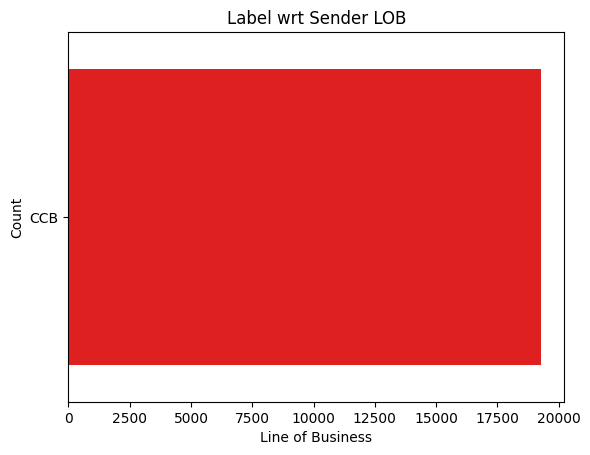

In [13]:
sns.countplot(data=is_fraud, y='Sender_lob', color='red')
plt.title('Label wrt Sender LOB')
plt.xlabel('Line of Business')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

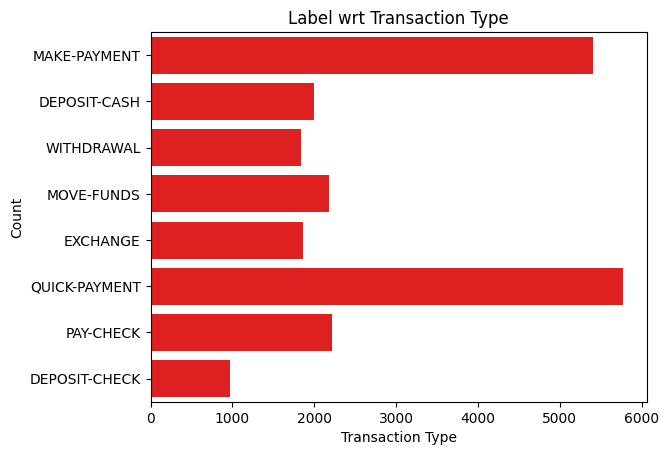

In [14]:
sns.countplot(data=is_fraud, y='Transaction_Type', color='red')
plt.title('Label wrt Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')

In [15]:
train.Transaction_Type.value_counts()

MAKE-PAYMENT     401875
QUICK-PAYMENT    156805
MOVE-FUNDS       129491
DEPOSIT-CASH      78947
DEPOSIT-CHECK     78805
EXCHANGE          77934
PAY-CHECK         77579
WITHDRAWAL        77251
Name: Transaction_Type, dtype: int64

We have noticed there are some null values. But these null values are not because the data is missing due to some error or data entry, rather there is no data present for such scenarios.<br>
For example:<br>
- Cases where reciever info should be missing:
    - WITHDRAWL
    - EXCHANGE
- Cases where sender info should be missing:
    - DEPOSIT-CASH
    - DEPOSIT-CHECK
- Cases where nothing should be be missing:
    - PAY-CHECK
    - MOVE-FUNDS
    - QUICK-PAYMENT
    - MAKE-PAYMENT

We can see that all the null values are justified, and we don't need to impute it like we impute regular missing values. Instead we will give all the missing values a unique token to separate it from the rest of dataset.

Alse, we won't need a few columns as those will be user specific and we want to get a generic model here.

In [16]:
dropped_columns = ['Transaction_Id', 'Sender_Id', 'Sender_Account', 'Sender_Sector', 'Sender_lob', 'Bene_Id', 'Bene_Account']

train = train.drop(dropped_columns, axis=1, errors='ignore').reset_index(drop=True)
test = test.drop(dropped_columns, axis=1, errors='ignore').reset_index(drop=True)

print(train.shape, test.shape)

(1078687, 6) (269672, 6)


In [17]:
train.head()

,Time_step,Sender_Country,Bene_Country,USD_amount,Label,Transaction_Type
0,2040-11-11 15:15:57,USA,GUERNSEY,84.89,0,MAKE-PAYMENT
1,2041-01-11 05:05:58,USA,MOZAMBIQUE,778.61,0,MAKE-PAYMENT
2,2023-03-22 11:14:06,USA,AMERICAN-SAMOA,16.82,0,MAKE-PAYMENT
3,2027-09-13 20:34:34,USA,USA,755.91,0,MAKE-PAYMENT
4,2025-03-16 11:44:18,USA,MALI,553.75,0,MAKE-PAYMENT


Before applying transformation, we need to bin the countries because of the 80-20 rule.

In [18]:
train.Sender_Country.value_counts()

USA                       718287
GERMANY                    52796
CANADA                     19745
THAILAND                     843
FRENCH-GUIANA                816
                           ...  
ZAMBIA                       307
BOSNIA-AND-HERZEGOVINA       295
TONGA                        292
UNITED-STATES                286
GREECE                       285
Name: Sender_Country, Length: 252, dtype: int64

In [146]:
class CountryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, top_countries, country_columns):
        self.top_countries = top_countries
        self.country_columns = country_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col_idx in self.country_columns:
            for row_idx in range(X.shape[0]):
                value = X[row_idx, col_idx]
                print(value)
                if value not in self.top_countries:
                    X[row_idx, col_idx] = 'Other'
        
        return X

In [20]:
class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, timestamp_column):
        self.timestamp_column = timestamp_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.timestamp_column] = pd.to_datetime(X[self.timestamp_column])
        X['Year'] = X[self.timestamp_column].dt.year
        X['Month'] = X[self.timestamp_column].dt.month
        X['Day'] = X[self.timestamp_column].dt.day
        X['Hour'] = X[self.timestamp_column].dt.hour
        X['Minute'] = X[self.timestamp_column].dt.minute
        X.drop(self.timestamp_column, axis=1, inplace=True)
        return X

In [21]:
timestamp_column = 'Time_step'
country_columns = ['Sender_Country', 'Bene_Country']
categorical_columns = ['Sender_Country', 'Bene_Country', 'Transaction_Type']
numerical_columns = ['Year','Month','Day','Hour','Minute','USD_amount']

In [85]:
y

,Time_step,Sender_Country,Bene_Country,USD_amount,Label,Transaction_Type
0,2040-11-11 15:15:57,USA,GUERNSEY,84.89,0,MAKE-PAYMENT
1,2041-01-11 05:05:58,USA,MOZAMBIQUE,778.61,0,MAKE-PAYMENT
2,2023-03-22 11:14:06,USA,AMERICAN-SAMOA,16.82,0,MAKE-PAYMENT
3,2027-09-13 20:34:34,USA,USA,755.91,0,MAKE-PAYMENT
4,2025-03-16 11:44:18,USA,MALI,553.75,0,MAKE-PAYMENT
...,...,...,...,...,...,...
1078682,2049-09-12 20:56:53,NaN,USA,868.61,0,DEPOSIT-CHECK
1078683,2031-10-16 13:05:00,TOKELAU,USA,559.85,0,MAKE-PAYMENT
1078684,2051-12-04 19:37:07,USA,NaN,715.58,0,WITHDRAWAL
1078685,2046-06-07 01:46:32,USA,MONGOLIA,34.46,0,MAKE-PAYMENT


In [130]:
timestamp = ColumnTransformer(
    transformers = [
        ('timestamp_transformer', TimestampTransformer(timestamp_column='Time_step'), ['Time_step'])
    ],
    remainder = 'passthrough'
)

In [133]:
scaler = ColumnTransformer(
    transformers = [
        ('standard_scaler', StandardScaler(), [0,1,2,3,4,7])
    ],
    remainder = 'passthrough'
)

In [134]:
numerical_pipeline = Pipeline(
    steps = [
        ('timestamp', timestamp),
        ('scaler',scaler)
    ]
)

numerical_pipeline

Pipeline(steps=[('timestamp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('timestamp_transformer',
                                                  TimestampTransformer(timestamp_column='Time_step'),
                                                  ['Time_step'])])),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  [0, 1, 2, 3, 4, 7])]))])

In [145]:
yy = numerical_pipeline.fit_transform(y.drop('Label', axis=1))
yy[0]

array([0.21730693223107878, 1.3106913223932581, -0.5406883226957558,
       0.5096367103722211, -0.8927709948736009, -0.791909564547134, 'USA',
       'GUERNSEY', 'MAKE-PAYMENT'], dtype=object)

In [147]:
imputer = ColumnTransformer(
    transformers = [
        ('simple_imputer', SimpleImputer(strategy='constant', fill_value='N/A'), [6,7])
    ],
    remainder = 'passthrough'
)

In [148]:
country_transformer = ColumnTransformer(
    transformers = [
        ('country_mapping', CountryTransformer(top_countries=['USA','GERMANY','CANADA'], country_columns=[6,7]), [6,7])
    ],
    remainder = 'passthrough'
)

In [149]:
one_hot = ColumnTransformer(
    transformers = [
        ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), [6,7,8])
    ],
    remainder = 'passthrough'
)

In [150]:
categorical_pipeline = Pipeline(
    steps = [
        ('imputer', imputer),
        ('country_transformer', country_transformer),
        ('one_hot', one_hot)
    ]
)

categorical_pipeline

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simple_imputer',
                                                  SimpleImputer(fill_value='N/A',
                                                                strategy='constant'),
                                                  [6, 7])])),
                ('country_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('country_mapping',
                                                  CountryTransformer(country_columns=[6,
                                                                                      7],
                                                                     top_countries=['USA',
                                                                                    'GERMANY',
                                                                                    'CANADA']),
                                                  [6, 7])])),
                ('one_hot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [6, 7, 8])]))])

In [143]:
preprocess_pipeline = Pipeline(
    [
        ('numerical', numerical_pipeline),
        ('categorical', categorical_pipeline)
    ]
)

preprocess_pipeline

Pipeline(steps=[('numerical',
                 Pipeline(steps=[('timestamp',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('timestamp_transformer',
                                                                   TimestampTransformer(timestamp_column='Time_step'),
                                                                   ['Time_step'])])),
                                 ('scaler',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('standard_scaler',
                                                                   StandardScaler(),
                                                                   [0, 1, 2, 3,
                                                                    4,
                                                                    7])]))])),
                ('categorical',
                 Pipe...
                                                                   [6, 7])])),
                                 ('country_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('country_mapping',
                                                                   CountryTransformer(country_columns=[6,
                                                                                                       7],
                                                                                      top_countries=['USA',
                                                                                                     'GERMANY',
                                                                                                     'CANADA']),
                                                                   [6, 7])])),
                                 ('one_hot',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False),
                                                                   [6, 7,
                                                                    8])]))]))])

In [151]:
yy = preprocess_pipeline.fit_transform(y.drop('Label', axis=1))
yy[0]

IndexError: index 6 is out of bounds for axis 1 with size 2

In [72]:
y = train.copy()

preprocess = ColumnTransformer(
    transformers = [
        ('simple_imputer', SimpleImputer(strategy='constant', fill_value='N/A'), country_columns),
        ('country_mapping', CountryTransformer(top_countries=['USA','GERMANY','CANADA'], country_columns=country_columns), country_columns),
        # ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns),
        ('timestamp_transformer', TimestampTransformer(timestamp_column=timestamp_column), [timestamp_column]),
        # ('standard_scaler', StandardScaler(), numerical_columns)
        
    ],
    remainder = 'drop'
)

zz = preprocess.fit_transform(y.drop('Label', axis=1))

In [82]:
categorical_preprocess = Pipeline(
    steps = [
        ('simple_imputer', SimpleImputer(strategy='constant', fill_value='N/A'), country_columns),
        ('country_mapping', CountryTransformer(top_countries=['USA','GERMANY','CANADA'], country_columns=country_columns), country_columns)
    ]
)
categorical_preprocess

ValueError: too many values to unpack (expected 2)

In [74]:
preprocess

ColumnTransformer(transformers=[('simple_imputer',
                                 SimpleImputer(fill_value='N/A',
                                               strategy='constant'),
                                 ['Sender_Country', 'Bene_Country']),
                                ('country_mapping',
                                 CountryTransformer(country_columns=['Sender_Country',
                                                                     'Bene_Country'],
                                                    top_countries=['USA',
                                                                   'GERMANY',
                                                                   'CANADA']),
                                 ['Sender_Country', 'Bene_Country']),
                                ('timestamp_transformer',
                                 TimestampTransformer(timestamp_column='Time_step'),
                                 ['Time_step'])])

In [73]:
zz[0]

array(['USA', 'GUERNSEY', 'USA', 'Other', 2040, 11, 11, 15, 15],
      dtype=object)

In [16]:

ct = ColumnTransformer([
    # ('simple_imputer', SimpleImputer(strategy='constant', fill_value='N/A'), col),
    ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Sender_Country'])
    ],
    remainder='passthrough'
)
ct.fit_transform(y)
# pd.DataFrame(ct.fit_transform(y), columns=ct.get_feature_names_out())

In [15]:
train = train.fillna('N/A')
train['Sender_Sector'] = train['Sender_Sector'].apply(lambda x: str(int(x)) if x!='N/A' else x)

test = test.fillna('N/A')
test['Sender_Sector'] = test['Sender_Sector'].apply(lambda x: str(int(x)) if x!='N/A' else x)

In [16]:
features_to_drop = ['Transaction_Id', 'Sender_lob']

train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

We will derive the extra features from timestamp that will help us.

In [27]:
y = train.copy()
# y = TimestampTransformer('Time_step').fit_transform(y)

In [19]:
train.columns

Index(['Time_step', 'Sender_Id', 'Sender_Account', 'Sender_Country',
       'Sender_Sector', 'Bene_Id', 'Bene_Account', 'Bene_Country',
       'USD_amount', 'Label', 'Transaction_Type'],
      dtype='object')

In [40]:
preprocess = ColumnTransformer(
    transformers = [
        ('timestamp_transformer', TimestampTransformer(timestamp_column=timestamp_column), [timestamp_column]),
        # ('one_hot_encoder', OneHotEncoder(), categorical_columns),
        # ('standard_scaler', StandardScaler(), numerical_columns),
    ],
    remainder = 'passthrough'
)

zz = preprocess.fit_transform(y.drop('Label', axis=1))

In [41]:
zz

array([[2040, 11, 11, ..., 'GUERNSEY', 84.89, 'MAKE-PAYMENT'],
       [2041, 1, 11, ..., 'MOZAMBIQUE', 778.61, 'MAKE-PAYMENT'],
       [2023, 3, 22, ..., 'AMERICAN-SAMOA', 16.82, 'MAKE-PAYMENT'],
       ...,
       [2051, 12, 4, ..., 'N/A', 715.58, 'WITHDRAWAL'],
       [2046, 6, 7, ..., 'MONGOLIA', 34.46, 'MAKE-PAYMENT'],
       [2049, 4, 13, ..., 'CANADA', 953.05, 'MOVE-FUNDS']], dtype=object)

In [36]:
y

,Time_step,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2051-12-30 14:37:07,COMPANY-2003012,ACCOUNT-2003019,GERMANY,59,JPMC-CLIENT-2003007,ACCOUNT-2003030,LIBERIA,2000.27,0,MOVE-FUNDS
1,2030-04-23 11:24:51,JPMC-CLIENT-550438,ACCOUNT-550452,USA,21626,BILL-COMPANY-550487,ACCOUNT-550488,BHUTAN,84.93,0,MAKE-PAYMENT
2,2039-01-04 05:15:45,JPMC-CLIENT-1126759,ACCOUNT-1126774,USA,27531,BILL-COMPANY-1127039,ACCOUNT-1127040,USA,13.81,0,MAKE-PAYMENT
3,2048-10-26 14:56:47,JPMC-CLIENT-1780040,ACCOUNT-1780070,IRAQ,7541,N/A,N/A,N/A,797.53,0,EXCHANGE
4,2034-09-09 12:25:18,JPMC-CLIENT-837717,ACCOUNT-837727,USA,12315,N/A,N/A,N/A,225.52,0,WITHDRAWAL
...,...,...,...,...,...,...,...,...,...,...,...
1348354,2022-03-15 10:24:00,COMPANY-2778,ACCOUNT-2788,ROMANIA,32716,JPMC-CLIENT-2774,ACCOUNT-2785,USA,100.96,0,MAKE-PAYMENT
1348355,2042-02-02 13:26:05,N/A,N/A,N/A,N/A,JPMC-CLIENT-1333528,ACCOUNT-1333543,USA,408.09,0,DEPOSIT-CASH
1348356,2025-05-21 11:34:19,JPMC-CLIENT-208193,ACCOUNT-208431,USA,38856,JPMC-COMPANY-208200,ACCOUNT-208212,CABO-VERDE,100.22,0,MAKE-PAYMENT
1348357,2045-08-31 20:16:28,JPMC-CLIENT-1575503,ACCOUNT-1575514,USA,22795,BILL-COMPANY-1575574,ACCOUNT-1575575,AFGHANISTAN,81.74,0,MAKE-PAYMENT
